# Multiclass Classification Modeling
To classify *Science* posts into different type of subfields (`flair` as reddits calls it) such as Health, Biology, Psychology, Medicine, Environment etc

## Importing packages and datafiles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.sparse import csr_matrix
import time, re, os

#to allow for progress tracking
from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score,  f1_score, recall_score # for model performance assessment
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeClassifier

#pycaret
from pycaret.classification import *

# imports for contextual embeddings
from transformers import pipeline # loading pre-trained models for contextual word embeddings (Hugging Face)


In [2]:
# Retrieve stored data from main notebook
%store -r science_df

## Data Cleaning

In [3]:
multi_df = science_df[['combined','link_flair_text']]

In [4]:
multi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24961 entries, 0 to 24960
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   combined         24961 non-null  object
 1   link_flair_text  24955 non-null  object
dtypes: object(2)
memory usage: 390.1+ KB


In [5]:
#drop missing data
multi_df.dropna(inplace = True)

In [6]:
flair_dict = dict(zip(multi_df['link_flair_text'].unique(),range(1,len(multi_df['link_flair_text'].unique())+1)))
flair_dict

{'Medicine': 1,
 'Social Science': 2,
 'Animal Science': 3,
 'Anthropology': 4,
 'Environment': 5,
 'Psychology': 6,
 'Health': 7,
 'Nanoscience': 8,
 'Engineering': 9,
 'Biology': 10,
 'Earth Science': 11,
 'Astronomy': 12,
 'Genetics': 13,
 'Economics': 14,
 'Paleontology': 15,
 'Chemistry': 16,
 'Neuroscience': 17,
 'Cancer': 18,
 'Mathematics': 19,
 'Epidemiology': 20,
 'Physics': 21,
 'Geology': 22,
 'Materials Science': 23,
 'Computer Science': 24,
 'Breaking News': 25,
 'Retraction': 26,
 'Best of r/science': 27}

In [7]:
# encode the y column
multi_df['link_flair_text'] = multi_df['link_flair_text'].apply(lambda x : flair_dict[x])

In [8]:
multi_df

,combined,link_flair_text
0,Researchers identify the sodium leak channel n...,1
1,New study explores why people drop out or don'...,2
2,Dogs can discriminate between human baseline a...,3
3,A new look at an extremely rare female infant ...,4
4,Concussions are associated with 60% increase i...,1
...,...,...
24956,10 Foods We Can Never Eat Again Because of Cli...,5
24957,10 Foods We Can Never Eat Again Because of Cli...,5
24958,"In an Astonishing Feat, a New Drug Reversed Pa...",1
24959,Bodies and Minds: Heavier Weight Targets Are D...,6


## Activate MLFlow

In [10]:
import mlflow 
mlflow.set_tracking_uri("sqlite:///mlflow.db") 
mlflow.set_experiment("GA-dsi32-project-3-multiclass1") 
mlflow.autolog()

2022/10/05 18:46:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/10/05 18:46:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2022/10/05 18:46:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/10/05 18:46:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


## Modeling using pycaret (TFIDF)

In [11]:
preprocess_pipeline = Pipeline([
    ('cvec', CountVectorizer(ngram_range = (1,2), stop_words = 'english', token_pattern = '\w+')), #we chose this based on the previous best model for binary classification. But we remove the binary as this is multiclass, hence, we want to feed more info into model
    ('tfidf', TfidfTransformer()) #we use this instead of tfidfvectorizer so that we can choose whether to turn it off or on without affecting the preprocessing done by countvectorizer
])


preprocess_transformer = ColumnTransformer([
    ('pipe', preprocess_pipeline, 'combined')
])

In [12]:
s = setup(multi_df, 
          target = 'link_flair_text',
          session_id = 42,
          use_gpu = True,
          fold = 5,
          log_experiment = True,
          experiment_name = 'GA-dsi32-project-3-multiclass1',
          silent = True,
          custom_pipeline = preprocess_transformer,
          preprocess = False #turn off the preprocess done by pycaret except for train_test_split and custom transformations passed in custom_pipeline param
         )

,Description,Value
0,session_id,42
1,Target,link_flair_text
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(24955, 2)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,1
8,Transformed Train Set,"(17468, 1)"
9,Transformed Test Set,"(7487, 1)"


In [13]:
%%time
best_model = compare_models(n_select = 20)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.5252,0.0000,0.3795,0.5151,0.5089,0.4775,0.4787,2.5140
svm,SVM - Linear Kernel,0.5208,0.0000,0.3776,0.5070,0.5016,0.4734,0.4747,1.0260
lr,Logistic Regression,0.4712,0.1789,0.2591,0.5003,0.4348,0.4038,0.4143,132.9820
et,Extra Trees Classifier,0.4654,0.1722,0.3073,0.4841,0.4457,0.4036,0.4095,34.1480
rf,Random Forest Classifier,0.4574,0.1725,0.2977,0.4733,0.4365,0.3946,0.4003,18.7600
lightgbm,Light Gradient Boosting Machine,0.4386,0.1717,0.3203,0.4323,0.4307,0.3837,0.3842,44.5040
gbc,Gradient Boosting Classifier,0.4270,0.1623,0.3191,0.4491,0.4225,0.3629,0.3694,354.7300
knn,K Neighbors Classifier,0.3883,0.1544,0.2724,0.3940,0.3772,0.3266,0.3283,3.0940
dt,Decision Tree Classifier,0.3395,0.1284,0.2406,0.3403,0.3374,0.2783,0.2785,13.7420
ada,Ada Boost Classifier,0.1877,0.1034,0.0725,0.0481,0.0629,0.0073,0.0327,4.7940


CPU times: total: 1h 56min 32s
Wall time: 1h 23min 4s
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000247523CA9D0> (for post_execute):


ValueError: Image size of 640x1973910 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 640x1973910 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x1.97391e+06 with 1 Axes>

ValueError: Image size of 640x1973910 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x1.97391e+06 with 1 Axes>

In [14]:
print(best_model[0])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=42, solver='auto',
                tol=0.001)


In [15]:
evaluate_model(best_model[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

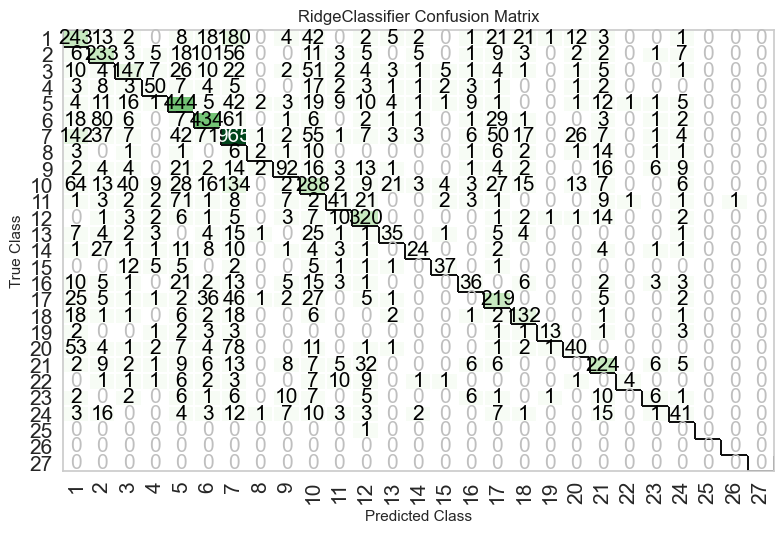

In [16]:
plot_model(best_model[0], plot = 'confusion_matrix')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5043,0.0000,0.3403,0.4986,0.4815,0.4499,0.4534
1,0.5238,0.0000,0.3525,0.5181,0.4996,0.4724,0.4754
2,0.5103,0.0000,0.3419,0.5108,0.4896,0.4573,0.4603
3,0.5202,0.0000,0.3611,0.5165,0.5002,0.4689,0.4717
4,0.5113,0.0000,0.3490,0.5195,0.4880,0.4566,0.4610
Mean,0.5140,0.0000,0.3490,0.5127,0.4918,0.4610,0.4644
Std,0.0071,0.0000,0.0075,0.0077,0.0072,0.0084,0.0080


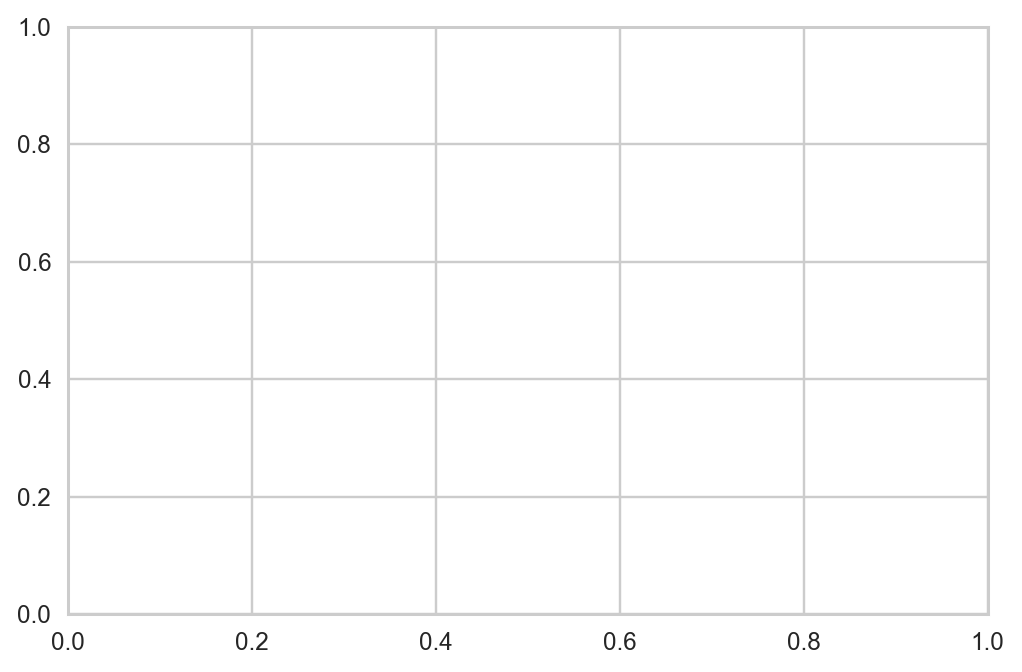

In [44]:
tuned_model = tune_model(best_model[0], choose_better = True)

## Modeling using pycaret (CountVector)
As there's sign of overfitting in the first modelling by pycaret using ridge classification. The accuracy on train data is good at 98%, but test accuracy is only 52%. Hence, we will 
- remove tfidf transformer
- relax the ngram parameter
- increase min_df to 2
- reduce max_df to 0.95


In [46]:
preprocess_pipeline = Pipeline([
    ('cvec', CountVectorizer(ngram_range = (1,1), stop_words = 'english', token_pattern = '\w+', min_df = 2, max_df = 0.95)), #we chose this based on the previous best model for binary classification. But we remove the binary as this is multiclass, hence, we want to feed more info into model
])


preprocess_transformer = ColumnTransformer([
    ('pipe', preprocess_pipeline, 'combined')
])

In [48]:
s = setup(multi_df, 
          target = 'link_flair_text',
          session_id = 42,
          use_gpu = True,
          fold = 5,
          log_experiment = True,
          experiment_name = 'GA-dsi32-project-3-multiclass1',
          silent = True,
          custom_pipeline = preprocess_transformer,
          preprocess = False #turn off the preprocess done by pycaret except for train_test_split and custom transformations passed in custom_pipeline param
         )

,Description,Value
0,session_id,42
1,Target,link_flair_text
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(24955, 2)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,1
8,Transformed Train Set,"(17468, 1)"
9,Transformed Test Set,"(7487, 1)"


In [ ]:
%%time
best_model = compare_models(n_select = 20)

IntProgress(value=0, description='Processing: ', max=74)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:33:55
Status,. . . . . . . . . . . . . . . . . .,Creating Logs
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.4858,0.1758,0.3476,0.4841,0.4770,0.4340,0.4350,10.5580
et,Extra Trees Classifier,0.4733,0.1713,0.3336,0.4708,0.4567,0.4172,0.4197,10.6680
rf,Random Forest Classifier,0.4646,0.1726,0.3118,0.4668,0.4462,0.4071,0.4100,7.5480
svm,SVM - Linear Kernel,0.4599,0.0000,0.3734,0.4539,0.4539,0.4090,0.4093,0.4260
ridge,Ridge Classifier,0.4463,0.0000,0.3298,0.4381,0.4378,0.3915,0.3922,3.7140
gbc,Gradient Boosting Classifier,0.4365,0.1660,0.3372,0.4705,0.4288,0.3682,0.3798,56.5940
dt,Decision Tree Classifier,0.3840,0.1327,0.2836,0.3811,0.3797,0.3263,0.3266,3.1600
knn,K Neighbors Classifier,0.2000,0.1278,0.1432,0.3155,0.2063,0.1380,0.1493,2.7320
ada,Ada Boost Classifier,0.1943,0.1018,0.0794,0.0482,0.0717,0.0186,0.0689,1.5400
dummy,Dummy Classifier,0.1834,0.1000,0.0397,0.0336,0.0568,0.0000,0.0000,0.3900


## Modeling using hugging face

### Custom Functions

In [38]:
# to output top prediction using different hugging face classifier
def hf_predict(x, labels, model):
    result = model(x, labels, multi_label=False)
    return result['labels'][0]

In [61]:
# to evaluate performance of hugging face models
def hf_evaluation(model, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred) #accuracy will be same as recal
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    hf_scores['accuracy'][model] = accuracy
    hf_scores['recall'][model] = recall
    hf_scores['precision'][model] = precision
    hf_scores['f1'][model] = f1

### Data Cleaning

In [40]:
# We take only 50 rows to run because previous run shows that 6 rows takes around 5 minutes. The purpose is to use these predicted class to see which scores are the highest
multi_df_hf_50, _ = train_test_split(multi_df, train_size = 50, stratify = multi_df['link_flair_text'])

In [41]:
label_ls = science_df['link_flair_text'].unique()
label_ls

array(['Medicine', 'Social Science', 'Animal Science', 'Anthropology',
       'Environment', 'Psychology', 'Health', 'Nanoscience',
       'Engineering', 'Biology', 'Earth Science', 'Astronomy', 'Genetics',
       'Economics', 'Paleontology', 'Chemistry', 'Neuroscience', 'Cancer',
       'Mathematics', 'Epidemiology', 'Physics', 'Geology',
       'Materials Science', 'Computer Science', nan, 'Breaking News',
       'Retraction', 'Best of r/science'], dtype=object)

In [42]:
%%time
#loop through the 5 popular zero shot classification on hugging face and evaluate the scores for each model
model_list = ['facebook/bart-large-mnli',
              'valhalla/distilbart-mnli-12-1',
              'valhalla/distilbart-mnli-12-3',               
              'typeform/distilbert-base-uncased-mnli',
              'Narsil/deberta-large-mnli-zero-cls',
              #'joeddav/xlm-roberta-large-xnli',  #cannot run
              #'BaptisteDoyen/camembert-base-xnli', #cannot run
              #'cross-encoder/nli-distilroberta-base',
              #'joeddav/bart-large-mnli-yahoo-answers',
              #'valhalla/distilbart-mnli-12-6'
             ]

for model in model_list:
    print(model)
    classifier = pipeline("zero-shot-classification", model=model)
    multi_df_hf_50[model] = multi_df_hf_50['combined'].progress_apply(hf_predict, args=(label_ls, classifier))

facebook/bart-large-mnli


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [10:22<00:00, 12.45s/it]


valhalla/distilbart-mnli-12-1


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:50<00:00,  5.80s/it]


valhalla/distilbart-mnli-12-3


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:49<00:00,  6.99s/it]


typeform/distilbert-base-uncased-mnli


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.48s/it]


Narsil/deberta-large-mnli-zero-cls


Some weights of the model checkpoint at Narsil/deberta-large-mnli-zero-cls were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:41<00:00, 14.02s/it]

CPU times: total: 3h 5min 59s
Wall time: 35min 15s


## Model Comparison

In [65]:
hf_scores = {'accuracy':{'Tfidf Pycaret':0.5252, 'Countvec Pycaret':0.4858}, 'recall':{'Tfidf Pycaret':0.3795, 'Countvec Pycaret':0.3476}, 'precision':{'Tfidf Pycaret':0.5151, 'Countvec Pycaret':0.4841}, 'f1':{'Tfidf Pycaret':0.5089, 'Countvec Pycaret':0.4770}}
pd.DataFrame(hf_scores)

,accuracy,recall,precision,f1
Tfidf Pycaret,0.5252,0.3795,0.5151,0.5089
Countvec Pycaret,0.4858,0.3476,0.4841,0.4770


In [66]:
#convert hugging face model result to corresponding numeric value and then log to dataframe hf_scores
for column in multi_df_hf_50.columns[2:7]:
    print(column)
    multi_df_hf_50[column+'-val'] = multi_df_hf_50[column].apply(lambda x: x if type(x) == float else flair_dict[x])
    multi_df_hf_50[column+'-val'].fillna(0, inplace = True)
    hf_evaluation(column,multi_df_hf_50['link_flair_text'], multi_df_hf_50[column+'-val'])

facebook/bart-large-mnli
valhalla/distilbart-mnli-12-1
valhalla/distilbart-mnli-12-3
typeform/distilbert-base-uncased-mnli
Narsil/deberta-large-mnli-zero-cls


In [67]:
pd.DataFrame(hf_scores)

,accuracy,recall,precision,f1
Tfidf Pycaret,0.5252,0.3795,0.515100,0.508900
Countvec Pycaret,0.4858,0.3476,0.484100,0.477000
facebook/bart-large-mnli,0.2400,0.2400,0.265000,0.244381
valhalla/distilbart-mnli-12-1,0.3000,0.3000,0.542857,0.348667
valhalla/distilbart-mnli-12-3,0.3400,0.3400,0.454667,0.358524
typeform/distilbert-base-uncased-mnli,0.3200,0.3200,0.431298,0.301917
Narsil/deberta-large-mnli-zero-cls,0.4400,0.4400,0.516333,0.459902


The ridge classification suggested by pycaret using tfidf has the best accuracy and F1 score. Hence, we will download that model

## Save Model

### Attempt to save best pycaret model directly
Although we are able to save the model directly generated by pycaret, It will not run because of the custom pipeline that we put in

In [18]:
save_model(best_model[0], 'best_multiclass_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='link_flair_text',
                                       time_features=[])),
                 ('custom_step',
                  ColumnTransformer(n_jobs=None, remainder='drop',
                                    sparse_threshold=0.3,
                                    transformer_weights=None,
                                    transformers...
                                                                                    token_pattern='\\w+',
                                                                                    tokenizer=None,
                   

In [19]:
loaded_model = load_model('best_multiclass_model')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='link_flair_text',
                                      time_features=[])),
                ('custom_step',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers...
                                                                                   token_pattern='\\w+',
                                                                                

### Manually run best model suggested by Pycaret (Ridge Classification) and save from mlflow

In [20]:
tfvec = TfidfVectorizer(ngram_range = (1,2), stop_words = 'english', token_pattern = '\w+')

In [21]:
X = tfvec.fit_transform(multi_df['combined'])

In [22]:
y = multi_df['link_flair_text']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [24]:
rc = RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=42, solver='auto',
                tol=0.001)

In [25]:
rc.fit(X_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=42, solver='auto',
                tol=0.001)

In [26]:
rc.score(X_train, y_train)

0.980711690532165

In [27]:
rc.score(X_test, y_test)

0.5241224555217182

In [28]:
y_pred = rc.predict(X_test)

In [29]:
precision_score(y_pred, y_test, average='weighted')

0.5834560709215025

In [ ]:
#Based on logged models on mlflow, this is the best model thus far. Hence, We will select this to deploy.
from mlflow.artifacts import download_artifacts

# Download the desired model from MLFlow to local directory
# Get the URL by following instructions in above image (full path will be from 'model' folder instead for non-hyperparameter runs)
full_path = './mlruns/3/a99dc4b981da4305af964b66a9a54365/artifacts/model' # paste copied full path from best_estimator
download_artifacts(full_path, dst_path='./models') # download from source: full_path, destination path: where this solution code notebook is located (can reference with '.')
os.rename('./models/model','./models/model_multiclass') #change name to 'model_multiclass'

In [ ]:
# Saving of tfidf vectoriser
import joblib
filename = './models/model_multiclass/tfidf.pkl'
joblib.dump(tfvec, filename)

['./models/model_multiclass/tfidf.pkl']

### Testing

In [9]:
#load model from mlflow
import mlflow.pyfunc
import joblib

# only run the following code on local machine only if you are able to download ./models/model_multiclass/model.pkl from github
# otherwise, download the model from this aws s3 code first, save it into the .models/model_multiclass folder: https://generalassemblydsi32.s3.ap-southeast-1.amazonaws.com/model_multiclass/model.pkl
# We have to do the above as github might have issue with file limit exceeding 50mb. Hence, file was uploaded on aws s3 instead.
model = mlflow.pyfunc.load_model(model_uri="./models/model_multiclass")

#load tfidf vectorizer from disk
tfidf = joblib.load("./models/model_multiclass/tfidf.pkl")

In [12]:
user_input1 = "Living in a corrupt environment makes you more likely to believe in conspiracy theories, regardless of your politics https://www.psypost.org/2022/09/living-in-a-corrupt-environment-makes-you-more-likely-to-believe-in-conspiracy-theories-regardless-of-your-politics-63974"
input_pred1 = model.predict(tfidf.transform(pd.Series(user_input1)))[0]

In [13]:
{'Expected':'Psychology', 'Result': {i for i in flair_dict if flair_dict[i]==input_pred1}}

{'Expected': 'Psychology', 'Result': {'Psychology'}}

In [14]:
user_input2 = "Physicist Stephen Hawking dies aged 76 We regret to hear that Stephen Hawking died tonight at the age of 76. We are creating a megathread for discussion of this topic here. The typical r/science comment rules will not apply and we will allow mature, open discussion. This post may be updated as we are able. A few relevant links: Stephen Hawking's AMA on /r/science. BBC's Obituary for Stephen Hawking. If you would like to make a donation in his memory, the Stephen Hawking Foundation has the Dignity Campaign to help buy adapted wheelchair equipment for people suffering from motor neuron diseases. You could also consider donating to the ALS Association to support research into finding a cure for ALS and to provide support to ALS patients. http://www.bbc.com/news/uk-43396008"
input_pred2 = model.predict(tfidf.transform(pd.Series(user_input2)))[0]

In [15]:
{'Expected':'Breaking News', 'Result': {i for i in flair_dict if flair_dict[i]==input_pred2}}

{'Expected': 'Breaking News', 'Result': {'Physics'}}

In [16]:
user_input3 = "Since legalizing cannabis in 2012, crime clearance rates are increasing faster in Washington and Colorado than the rest of country, suggesting that legalization may free police to focus on more serious crimes. https://www.google.com/amp/s/www.washingtonpost.com/amphtml/business/2018/07/18/does-legal-weed-make-police-more-effective/"
input_pred3 = model.predict(tfidf.transform(pd.Series(user_input3)))[0]

In [17]:
{'Expected':'Social Science', 'Result': {i for i in flair_dict if flair_dict[i]==input_pred3}}

{'Expected': 'Social Science', 'Result': {'Social Science'}}

In [18]:
user_input4 = "No evidence to support link between violent video games and behaviour - Researchers at the University of York have found no evidence to support the theory that video games make players more violent. https://www.york.ac.uk/news-and-events/news/2018/research/no-evidence-to-link-violence-and-video-games/"
input_pred4 = model.predict(tfidf.transform(pd.Series(user_input4)))[0]

In [19]:
{'Expected':'Psychology', 'Result': {i for i in flair_dict if flair_dict[i]==input_pred4}}

{'Expected': 'Psychology', 'Result': {'Psychology'}}